In [ ]:
import os
import json
from collections import defaultdict
from tasks import *
path = 'halu_analysis'
merged_responses = {}
problem_num = 500
dataset_loc = 'dataset'


paths = ['halu_analysis']
task_number = {}

all_files = os.listdir(paths[0])
print(all_files)

distance=False
mis=False


for f in all_files:
    if len(f.split('_')) < 2:
        continue
    llm, task, difficulty = f.split('_')[0], f.split('_')[1], f.split('_')[2].split('.')[0]
    
    task = task + "_" + difficulty
    
    with open(f'{path}/{f}', 'r') as file:
        response_dict = json.load(file)
    
    if task not in ['MCP_easy','MCP_hard','MVC_easy','MVC_hard','Distance_easy','Distance_hard','Neighbor_easy','Neighbor_hard']:
        continue
    
    
    for i in range(0, problem_num):
        if task not in merged_responses:
            merged_responses[task] = defaultdict(dict)
        merged_responses[task][i][llm] = response_dict[str(i)][llm]

task_list = list(merged_responses.keys())
task_list = sorted(task_list)

In [ ]:
score = {}
node_size = {}
# task_list = ['GED', 'MCP', 'MCS', 'TSP']
# model_list = ['deepseek', 'llama', 'llama8b', 'gpt', 'gpt4', 'claude', 'mixtral']

from tasks import *

for task_name in task_list:
    print(task_name)
    difficulty=task_name.split('_')[1]
    cur_name=task_name.split('_')[0]

    task= globals()[cur_name + '_Task'](dataset_loc)
    task.load_dataset(difficulty)
    score[task_name] = defaultdict(dict)
    node_size[task_name] = defaultdict(dict)
    for i in range(0, problem_num):
        score[task_name][i]['gt'] = task.problem_set[i]['exact_answer']
        if task_name in ['GED', 'TSP', 'MCS'] and difficulty=='hard':
            score[task_name][i]['gt'] = task.problem_set[i]['approx_answer']
        for llm in merged_responses[task_name][i].keys():
            if llm == 'problem':
                continue
            r = merged_responses[task_name][i][llm]
            if r is None:
                r = ''
                print(i, llm, task_name)
            # print(r)
            # r = r.replace('\\text{', '').replace('}', '').replace('\[', '').replace('\]', '')
            score[task_name][i][llm] = task.check_solution(i, r)
            
            if cur_name in ['GED','MCS']:
                g = task.problem_set[i]['graph'][0]
                node_size[task_name][i][llm] = g.number_of_nodes()
            else:
                g = task.problem_set[i]['graph']
                node_size[task_name][i][llm] = g.number_of_nodes()
# json.dump(score, open('score.json', 'w'))

In [ ]:
import numpy as np
import pickle
#metrics = defaultdict(dict)
metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
less_is_better = ['Distance']
results = []
cnt = 0
for task in task_list:
    cnt = cnt + 1
    print(task)
    model_list = list(score[task][0].keys())
    model_list.remove('gt')
    cur_task = task.split('_')[0]
    for model in model_list:
        if cnt % 2 != 0:
            for i in range(5,31):
                metrics[cur_task][model][str(i)]=[]
        for i in range(0, problem_num):
            node_num = node_size[task][i][model]
            if node_num <5 or node_num >30:
                continue

            metrics[cur_task][model][str(node_num)].append(score[task][i][model]==-2)
            
        if cnt %2 ==0:  
            avg=[]
            avg.append(cur_task)
            avg.append(model)
            for i in range(5,31):
                avg.append(np.mean(metrics[cur_task][model][str(i)]))
        
            result = tuple(avg)
            print(result)
            results.append(result)

results = sorted(results, key=lambda x: x[1])

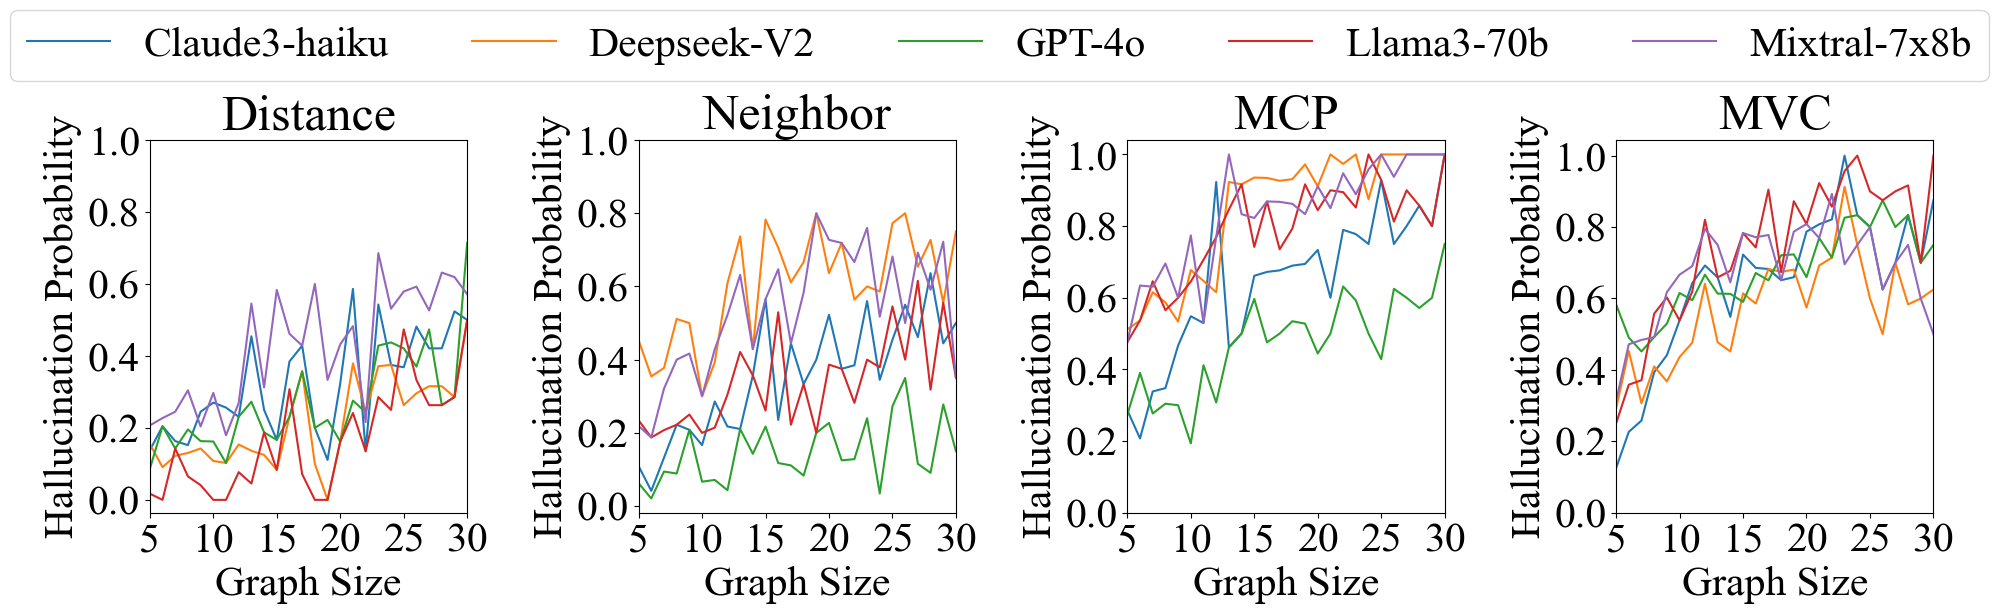

In [20]:
import matplotlib.pyplot as plt

# 修改全局字体和大小
plt.rcParams.update({'font.size': 30, 'font.family': 'Times New Roman'})

# 假设 results 是一个列表，其中每个元素都是一个元组，形式如下：
# (task, model, size5, size6, ..., size30)

# 获取所有任务的唯一列表
tasks = set(result[0] for result in results)

# 创建一个大的图形和轴
fig, axs = plt.subplots(1, len(tasks), figsize=(20, 6))  # 设置图形大小

# 为每个任务绘制折线图
for i, task in enumerate(tasks):
    # 过滤出当前任务的所有结果
    task_results = [result for result in results if result[0] == task]

    # 记录已经绘制的模型，确保每个模型只有一个图例
    plotted_models = []

    # 为每个模型绘制折线
    for result in task_results:
        model = result[1]
        if model not in ['gpt4', 'deepseek', 'claude', 'llama', 'mixtral'] or model in plotted_models:
            continue
        feasibility_values = result[2:]  # 幻觉概率值
        sizes = list(range(5, 31))  # 图的规模，从5到30

        # 设置标签
        label = model

        # 绘制折线
        axs[i].plot(sizes, feasibility_values, label=label)
        plotted_models.append(model)

    # 设置子图标题和轴标签
    axs[i].set_title(f'{task}')
    axs[i].set_xlabel('Graph Size')
    axs[i].set_ylabel('Hallucination Probability')
    axs[i].set_xlim(5, 20)  # 设置横坐标范围
    axs[i].set_xticks([5, 10, 15, 20,25,30])  # 设置横坐标刻度
    axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # 设置纵坐标刻度


# 添加图例
handles, labels = axs[i].get_legend_handles_labels()
labels = ['Claude3-haiku','Deepseek-V2','GPT-4o','Llama3-70b','Mixtral-7x8b']
unique_labels = labels
unique_handles = [handles[labels.index(label)] for label in unique_labels]
fig.legend(unique_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=30)  # 将图例放在上方中间，并且不要留太多空白

# 调整子图之间的间距
plt.tight_layout()

plt.savefig('halu_evaluation_appendix1.pdf', format='pdf', dpi=1200, bbox_inches='tight')  # 增加清晰度
# 显示图表
plt.show()
